# Recurrent Neural Networks

本次作業是要讓同學接觸 NLP 當中一個簡單的 task —— 語句分類（文本分類）

給定一個語句，判斷他有沒有惡意（負面標 1，正面標 0）

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# path_prefix = 'drive/My Drive/Colab Notebooks/hw4 - Recurrent Neural Network'
path_prefix = './'

### Download Dataset
有三個檔案，分別是 training_label.txt、training_nolabel.txt、testing_data.txt

- training_label.txt：有 label 的 training data（句子配上 0 or 1，+++$+++ 只是分隔符號，不要理它）
    - e.g., 1 +++$+++ are wtf ... awww thanks !

- training_nolabel.txt：沒有 label 的 training data（只有句子），用來做 semi-supervised learning
    - ex: hates being this burnt !! ouch

- testing_data.txt：你要判斷 testing data 裡面的句子是 0 or 1

    >id,text

    >0,my dog ate our dinner . no , seriously ... he ate it .

    >1,omg last day sooon n of primary noooooo x im gona be swimming out of school wif the amount of tears am gona cry

    >2,stupid boys .. they ' re so .. stupid !

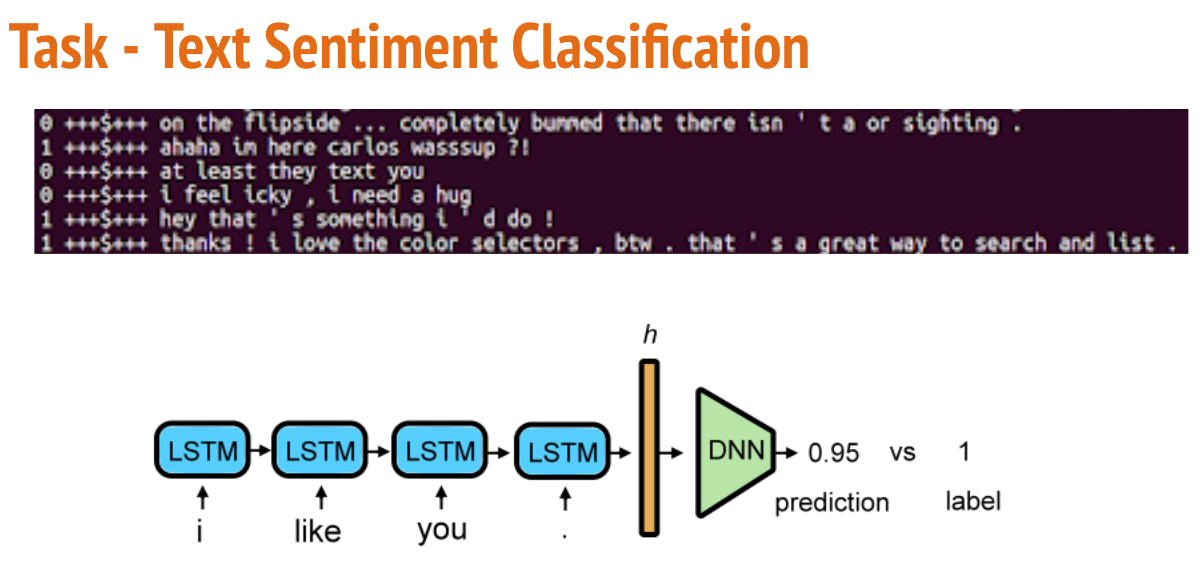
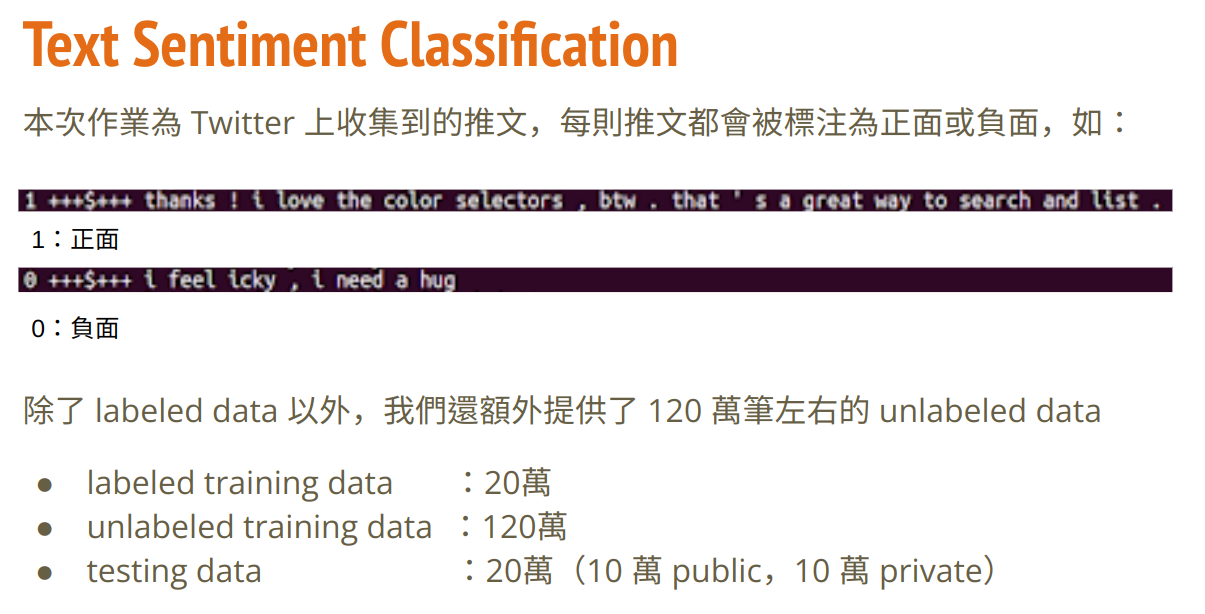

In [2]:
!gdown --id '1lz0Wtwxsh5YCPdqQ3E3l_nbfJT1N13V8' --output data.zip
!unzip data.zip
!ls

In [3]:
# this is for filtering the warnings
import warnings
warnings.filterwarnings('ignore')

### Utils

In [4]:
# utils.py
# 這個 block 用來先定義一些等等常用到的函式
!cat utils.py
from utils import *

import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F

def load_training_data(path='training_label.txt'):
    # 把 training 時需要的 data 讀進來
    # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
    if 'training_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
        return x

def load_testing_data(path='testing_data'):
    # 把 testing 時需要的 data 讀進來
    with open(path, 'r') as f:
        lines = f.readlines()
        X = ["".join(line.strip('\n').split(",")[1:]).strip() for line in lines[1:]]
        X = [sen.split(' ') for sen in X]
    return X

def evaluation(o

### Train Word to Vector

In [5]:
# w2v.py
# 這個 block 是用來訓練 word to vector 的 word embedding
# 注意！這個 block 在訓練 word to vector 時是用 cpu，可能要花到 10 分鐘以上

!pip install scipy==1.2.1
!pip install gensim==3.0
!cat w2v.py
!python w2v.py

# w2v.py
# 這個 block 是用來訓練 word to vector 的 word embedding
# 注意！這個 block 在訓練 word to vector 時是用 cpu，可能要花到 10 分鐘以上
import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

def train_word2vec(x):
    # 訓練 word to vector 的 word embedding
    model = word2vec.Word2Vec(x, size=250, window=5, min_count=5, workers=12, iter=10, sg=1)
    # sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
    return model

def train_word2vec_cbow(x):
    # 訓練 word to vector 的 word embedding
    model = word2vec.Word2Vec(x, size=250, window=5, min_count=5, workers=12, iter=10, sg=0)
    # sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
    return model

def load_training_data(path='training_label.txt'):
    # 把 training 時需要的 data 讀進來
    # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
    if 'training_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()


### Data Preprocess

In [6]:
!cat preprocess.py
from preprocess import *

# preprocess.py
# 這個 block 用來做 data 的預處理
from torch import nn
from gensim.models import Word2Vec
import torch

class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # 把之前訓練好的 word to vec 模型讀進來
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # 把 word 加進 embedding，並賦予他一個隨機生成的 representation vector
        # word 只會是 "<PAD>" 或 "<UNK>"
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        

### Dataset

In [7]:
# data.py
!cat data.py
from data import *

# 實作了 dataset 所需要的 '__init__', '__getitem__', '__len__'
# 好讓 dataloader 能使用
import torch
from torch.utils import data

class TwitterDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

### Model

In [8]:
# model.py
# 這個 block 是要拿來訓練的模型
import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix 住，如果 fix_embedding 為 False，在訓練過程中，embedding 也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

### Train

In [9]:
# train.py
!cat train.py
from train import *

# 這個 block 是用來訓練模型的
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from utils import *

def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))
    model.train() # 將 model 的模式設為 train，這樣 optimizer 就可以更新 model 的參數
    criterion = nn.BCELoss() # 定義損失函數，這裡我們使用 binary cross entropy loss
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr) # 將模型的參數給 optimizer，並給予適當的 learning rate
    total_loss, total_acc, best_acc = 0, 0, 0
    for epoch in range(n_epoch):
        total_loss, total_acc = 0, 0
        # 這段做 training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs

### Test

In [10]:
# test.py
!cat test.py
from train import testing

# test.py
# 這個 block 用來對 testing_data.txt 做預測
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            outputs[outputs>=0.5] = 1 # 大於等於 0.5 為正面
            outputs[outputs<0.5] = 0 # 小於 0.5 為負面
            ret_output += outputs.int().tolist()
    
    return ret_output

### Main - skip_gram

In [11]:
# # main.py
# import os
# import torch
# import argparse
# import numpy as np
# from torch import nn
# from gensim.models import word2vec
# from sklearn.model_selection import train_test_split

# # 通過 torch.cuda.is_available() 的回傳值進行判斷是否有使用 GPU 的環境，如果有的話 device 就設為 "cuda"，沒有的話就設為 "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 處理好各個 data 的路徑
# train_with_label = os.path.join(path_prefix, 'training_label.txt')
# train_no_label = os.path.join(path_prefix, 'training_nolabel.txt')
# testing_data = os.path.join(path_prefix, 'testing_data.txt')

# w2v_path = os.path.join(path_prefix, 'w2v_all.model') # 處理 word to vec model 的路徑

# # 定義句子長度、要不要固定 embedding、batch 大小、要訓練幾個 epoch、learning rate 的值、model 的資料夾路徑
# sen_len = 20
# fix_embedding = True # fix embedding during training
# batch_size = 128
# epoch = 20
# lr = 0.001
# # model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
# model_dir = path_prefix # model directory for checkpoint model

# print("loading data ...") # 把 'training_label.txt' 跟 'training_nolabel.txt' 讀進來
# train_x, y = load_training_data(train_with_label)
# train_x_no_label = load_training_data(train_no_label)

# # 對 input 跟 labels 做預處理
# preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
# embedding = preprocess.make_embedding(load=True)
# train_x = preprocess.sentence_word2idx()
# y = preprocess.labels_to_tensor(y)

# # 製作一個 model 的對象
# model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
# model = model.to(device) # device為 "cuda"，model 使用 GPU 來訓練（餵進去的 inputs 也需要是 cuda tensor）

# # 把 data 分為 training data 跟 validation data（將一部份 training data 拿去當作 validation data）
# X_train, X_val, y_train, y_val = train_x[:180000], train_x[180000:], y[:180000], y[180000:]

# # 把 data 做成 dataset 供 dataloader 取用
# train_dataset = TwitterDataset(X=X_train, y=y_train)
# val_dataset = TwitterDataset(X=X_val, y=y_val)

# # 把 data 轉成 batch of tensors
# train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
#                                             batch_size = batch_size,
#                                             shuffle = True,
#                                             num_workers = 8)

# val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
#                                             batch_size = batch_size,
#                                             shuffle = False,
#                                             num_workers = 8)

# # 開始訓練
# # training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

### Main - CBOW

In [12]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

# 通過 torch.cuda.is_available() 的回傳值進行判斷是否有使用 GPU 的環境，如果有的話 device 就設為 "cuda"，沒有的話就設為 "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 處理好各個 data 的路徑
train_with_label = os.path.join(path_prefix, 'training_label.txt')
train_no_label = os.path.join(path_prefix, 'training_nolabel.txt')
testing_data = os.path.join(path_prefix, 'testing_data.txt')

w2v_path = os.path.join(path_prefix, 'w2v_all_cbow.model') # 處理 word to vec model 的路徑

# 定義句子長度、要不要固定 embedding、batch 大小、要訓練幾個 epoch、learning rate 的值、model 的資料夾路徑
sen_len = 20
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 5
lr = 0.001
# model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
model_dir = path_prefix # model directory for checkpoint model

print("loading data ...") # 把 'training_label.txt' 跟 'training_nolabel.txt' 讀進來
train_x, y = load_training_data(train_with_label)
train_x_no_label = load_training_data(train_no_label)

# 對 input 跟 labels 做預處理
preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)

# 製作一個 model 的對象
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device) # device為 "cuda"，model 使用 GPU 來訓練（餵進去的 inputs 也需要是 cuda tensor）

# 把 data 分為 training data 跟 validation data（將一部份 training data 拿去當作 validation data）
X_train, X_val, y_train, y_val = train_x[:180000], train_x[180000:], y[:180000], y[180000:]

# 把 data 做成 dataset 供 dataloader 取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把 data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

# 開始訓練
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

loading data ...
Get embedding ...
loading word to vec model ...
get words #55777
total words: 55779
sentence count #200000
start training, parameter total:14186101, trainable:241351

[ Epoch1: 1407/1407 ] loss:0.392 acc:19.531 
Train | Loss:0.47184 Acc: 77.256
Valid | Loss:0.43837 Acc: 79.026 
saving model with acc 79.026
-----------------------------------------------
[ Epoch2: 1407/1407 ] loss:0.460 acc:19.531 
Train | Loss:0.42023 Acc: 80.499
Valid | Loss:0.42213 Acc: 80.001 
saving model with acc 80.001
-----------------------------------------------
[ Epoch3: 1407/1407 ] loss:0.488 acc:20.312 
Train | Loss:0.39773 Acc: 81.866
Valid | Loss:0.42199 Acc: 80.125 
saving model with acc 80.125
-----------------------------------------------
[ Epoch4: 1407/1407 ] loss:0.197 acc:24.219 
Train | Loss:0.37751 Acc: 82.849
Valid | Loss:0.42075 Acc: 80.180 
saving model with acc 80.180
-----------------------------------------------
[ Epoch5: 1407/1407 ] loss:0.536 acc:19.531 
Train | Loss:0.

### Main - CBOW (Semi-supervised Learning)

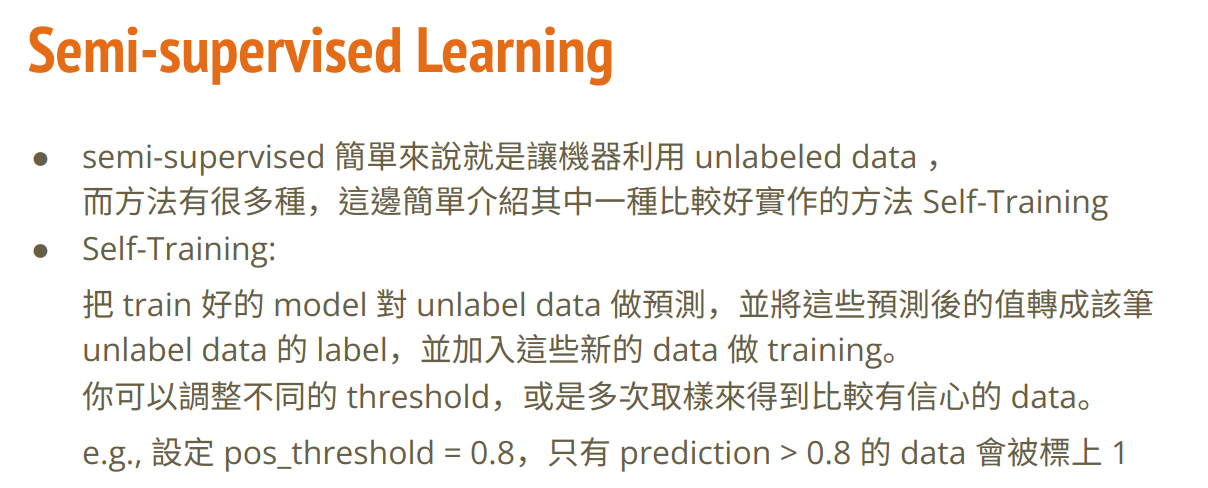

In [13]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

# 通過 torch.cuda.is_available() 的回傳值進行判斷是否有使用 GPU 的環境，如果有的話 device 就設為 "cuda"，沒有的話就設為 "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 處理好各個 data 的路徑
train_with_label = os.path.join(path_prefix, 'training_label.txt')
train_no_label = os.path.join(path_prefix, 'training_nolabel.txt')
testing_data = os.path.join(path_prefix, 'testing_data.txt')

w2v_path = os.path.join(path_prefix, 'w2v_all_cbow.model') # 處理 word to vec model 的路徑

# 定義句子長度、要不要固定 embedding、batch 大小、要訓練幾個 epoch、learning rate 的值、model 的資料夾路徑
sen_len = 20
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 5
lr = 0.001
# model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
model_dir = path_prefix # model directory for checkpoint model

print("loading data ...") # 把 'training_label.txt' 跟 'training_nolabel.txt' 讀進來
train_x, y = load_training_data(train_with_label)
train_x_no_label = load_training_data(train_no_label)

# 對 input 跟 labels 做預處理
preprocess = Preprocess(train_x , sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)

# 製作一個 model 的對象
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device) # device為 "cuda"，model 使用 GPU 來訓練（餵進去的 inputs 也需要是 cuda tensor）

# 把 data 分為 training data 跟 validation data（將一部份 training data 拿去當作 validation data）
X_train, X_val, y_train, y_val = train_x[:180000], train_x[180000:], y[:180000], y[180000:]

# 把 data 做成 dataset 供 dataloader 取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把 data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)



# 開始訓練
# training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

loading data ...
Get embedding ...
loading word to vec model ...
get words #55777
total words: 55779


### Self.Training

In [14]:
train_x_no_label = preprocess.unlabel_sentence_word2idx(train_x_no_label)

no_label_dataset = TwitterDataset(X=train_x_no_label, y=None)
# 把 data 轉成 batch of tensors
no_label_loader = torch.utils.data.DataLoader(dataset = no_label_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

In [15]:
for idx, bsz in enumerate(no_label_loader):
    print(bsz)
    break

tensor([[   50,  6568,     0,  ..., 55777, 55777, 55777],
        [10540,  6462, 24244,  ..., 18092,   600,    29],
        [   18,   335,    52,  ..., 55777, 55777, 55777],
        ...,
        [  165,   144,   908,  ...,   844,    25,    18],
        [ 4755,   548,    70,  ...,   139,   840,   125],
        [   84,     0,    42,  ..., 55777, 55777, 55777]])


In [ ]:
print("Origin X size:{}".format(X_train.size()))
print("Origin y size:{}".format(y_train.size()))

# from tqdm import tqdm
# print('-----------------------------------------------')
pos_thres = 0.8
model.eval()
# with torch.no_grad():
for i, inputs in enumerate(no_label_loader):
    inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
    u_outputs = model(inputs) # 將 input 餵給模型
    u_outputs = u_outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()

    fake_label = torch.where(u_outputs < (1 - pos_thres), torch.tensor(0.0).to(device), u_outputs)
    fake_label = torch.where(fake_label > pos_thres, torch.tensor(1.0).to(device), fake_label)
    fake_label = torch.where(
        ((fake_label < pos_thres) & (fake_label > (1 - pos_thres))) \
        , torch.tensor(-1.0).to(device), fake_label)

    indices = ((fake_label == 1) | (fake_label == 0)).nonzero().squeeze().cpu().numpy().tolist()

    add_inputs = inputs[indices].cpu()
    add_labels = fake_label[indices].cpu()

    X_train = torch.cat([X_train, add_inputs])
    y_train = torch.cat([y_train, add_labels])
    print("extra size:{}".format(X_train.size()), end='\r')
    # print("Now y extra size:{}".format(y_train.size()))
                
print("Now X size:{}".format(X_train.size()))
print("Now y size:{}".format(y_train.size()))

# 把 data 做成 dataset 供 dataloader 取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把 data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)        

NameError: name 'X_train' is not defined

In [ ]:
# 開始訓練
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

### Predict and Write to csv file

In [ ]:
# 開始測試模型並做預測
print("loading testing data ...")
test_x = load_testing_data(testing_data)
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = TwitterDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

# 寫到 csv 檔案供上傳 Kaggle
tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"label":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'predict.csv'), index=False)
print("Finish Predicting")

# 以下是使用 command line 上傳到 Kaggle 的方式
# 需要先 pip install kaggle、Create API Token，詳細請看 https://github.com/Kaggle/kaggle-api 以及 https://www.kaggle.com/code1110/how-to-submit-from-google-colab
# kaggle competitions submit [competition-name] -f [csv file path]] -m [message]
# e.g., kaggle competitions submit ml-2020spring-hw4 -f output/predict.csv -m "......"

#### Check where the files are

In [ ]:
!pwd
!ls